# Switzerland and Black Slavery

## Header 
Author : Amina Matt and Yichen Wang  
Date created : 14.10.2021  
Date last modified : 22.12.2021  
Python version : 3.8  
Description : Natural Language processing of the [CARICOM Compilation Archive (CCA)](https://louverture.ch/cca/).
The goal is to obtain 
- person name
- origin, i.e. location in Switzerland
- colonial location 
- date
- activities
for each actors identified in the CCA.

## Librairies

In [69]:
# -*- coding: utf-8 -*-

import nltk #Natural Language Toolkit is a natural language programming library
import pandas as pd #Pandas provides data structure and data analysis tools
from pandas.io.json import json_normalize
# The following libraries are used for Named Entities Recognition and BIO taggings
from nltk import pos_tag
from nltk.tag import StanfordNERTagger
from nltk.tokenize import word_tokenize
from nltk.chunk import conlltags2tree
from nltk.tree import Tree

#Other
import random

## Initialization

In [71]:
#PATHS
DATA_FOLDER = './data/'
caricom_sample = DATA_FOLDER +'Caricom_Archive_Sample_Schema1.txt' #sample text for testing 
caricom = DATA_FOLDER +'Caricom_Archive.txt'

# Text separation into items 
In the [primary text source](https://louverture.ch/cca/), in each section there is a list of item/entries. Most items are separated by a return and the **=>** starting string. Each item references a different actor of colonial entreprise. The first step is to retrieve each item separately and append its index for future colonial location retrieval. Indeed the table of contents is mainly organized by colonial location (some sections don't refer explicitly to geographical location, and are treated separatly).
Note that some items are separated with other symbols or in sublists. 

In [81]:
def divide_items(textFilePath):
    '''
    Input: path for the text file of the website
    Output: list of strings, where each element is an item, i.e. a separate entry in the document of origin with its colonial index appended.
    Requirements: -
    Description: separate the items based on the '\n' '=>' string that characterize a new entry
    '''
    f = open(textFilePath,"r")
    item = []
    flagIntro = False
    
    #reading file 
    for line in f: 
        
        if (line == '1 CARICOM MEMBER STATES\n') :
            flagIntro = True #the intro has been fully read
            print('The introduction has been read. Retrieving entries.')
        
        # Index retrieving for colonial location 
        if flagIntro : #check if line is a TOC entry
            if (line[0].isdigit()) and  (line[1] == '.') and (line[2].isdigit()) : #We have a subTOC entry, level n.n
                
                #For United States
                if (line[0] == '3') and (line[3] == '.'):
                    colonialIndex = line[0:5] 
                #For other subcategories
                else :
                    colonialIndex = line[0:3]
                    colonialIndex = colonialIndex.replace('\n','')
              
                #print('the colonial index is ' + str(colonialIndex))

        # Items retrieving     
        if (line != '\n'):
            if (line[0] == '=') and (line[1] == '>'):
                item_text = ''
                while (line != '\n'):
                    item_text = item_text + line
                    line = f.readline()
                
                #Once the item is read we add its colonial index (corresponding to the TOC entry)
                #We add the index at the end to retrieve it easily
                item_text = item_text.replace('\n','') 
                #print(item_text)
                item_text = item_text + (' '+colonialIndex)
                #print('The text item now has the colonial index'+item_text)
                item.append(item_text)
    
    f.close()
    return item 

In [82]:
text_items = divide_items(caricom)
items_total = len(text_items)
print(f'There are {len(text_items)} items in total.')

The introduction has been read. Retrieving TOC and entries.
There are 464 items in total.


In [83]:
print(f'This is one text item:\n{text_items[random.randrange(len(text_items))]}.\n')

This is one text item:
=> Swiss neuroanatomist, psychiatrist and eugenicist Auguste Forel (1848–1931) reported from his trip through the Caribbean in 1878 (voyage from Jamaica to Barbados to St. Lucia) that he could no longer stand «the stench of the negroes» in his cabin and that there were a lot of «negroes and mulattoes» from Haiti on the boat, «whose childish chatter (in French) made him break out laughing.» 1.7.



In [84]:
print('Note the index at the end of the text')

Note the index at the end of the text


## Table of Contents processing
As mentioned earlier most sections and subsections are geographical locations. However some are regions, as "French West Indies" or concept as the "Structural Contribution" section. 
We defined here what is the information that should go the *colonial location* property.

In [93]:
def tocList_func(textFilePath):
    '''
    Input: path for the text file of the website
    Output: list of index number and the corresponding clean title for colonial location 
    Requirements: -
    Description: Retrieve all toc entries and replace the ones that have ambiguous names
    '''
    f = open(textFilePath,"r")
    tocList = []
    for line in f: 
        if (line == '1 CARICOM MEMBER STATES\n') :
            break
        else : 
            if (line[0].isdigit()) and  (line[1] == '.') and (line[2].isdigit())  : #we have a subTOC entry, level n.n
                toc = (line[0:3],line[4:-1])
            #For United States
                if (line[0] == '3') and (line[3] == '.'):
                    toc = (line[0:5],line[6:-1]) #print(toc)
                tocList.append(toc)
    #manual cleaning 
    tocList[5]=('1.6','Guyana')
    tocList[9]=('1.7','Haiti')
    tocList[19]=('2.2','Netherlands Antilles')
    tocList[20]=('2.3','French West Indies')
    tocList[21]=('2.4','Danish West Indies')
    tocList[24]=('3.1','North America')
    tocList[38]=('3.2','Brazil')
    #as these concern structural contribution over all the region there are in switzerland
    tocList[41]=('4.1','Switzerland')
    tocList[42]=('4.2','Switzerland')
    tocList[43]=('4.3','Switzerland')
    f.close()
    return tocList
tocList = tocList_func(caricom)   

## Named Entities Recognition with NER Stanford 
The first objective is to extract information of interest from the text. In this case we are interested in person's names, locations and activities. The first step towards this goal is to use Named Entities Recognition to recognize which words contain the information we are looking for.

In [8]:
#Stanford NER 
NER_FOLDER = './NER-Standford/stanford-ner-2020-11-17'
CLASSIFIER_PATH = NER_FOLDER+'/classifiers/'
JAR_PATH = NER_FOLDER+'/stanford-ner.jar'

#classifiers
classifier_3 = 'english.all.3class.distsim.crf.ser.gz'#3 class model for recognizing locations, persons, and organizations
classifier_4 = 'english.conll.4class.distsim.crf.ser.gz'#4 class model for recognizing locations, persons, organizations, and miscellaneous entities
classifier_7 = 'english.muc.7class.distsim.crf.ser.gz' #7 class model for recognizing locations, persons, organizations, times, money, percents, and dates

st = StanfordNERTagger(CLASSIFIER_PATH+classifier_7, JAR_PATH, encoding='utf-8')



#Extracting named-entities
text = open(caricom_sample, 'r').read()
tokenized_text = word_tokenize(text)
classified_text = st.tag(tokenized_text)

print(classified_text)

[('=', 'O'), ('>', 'O'), ('François', 'PERSON'), ('Aimé', 'PERSON'), ('Louis', 'PERSON'), ('Dumoulin', 'PERSON'), ('(', 'O'), ('1753-1834', 'O'), (')', 'O'), ('from', 'O'), ('Vevey', 'LOCATION'), ('(', 'O'), ('Canton', 'LOCATION'), ('of', 'O'), ('BerneVaud', 'O'), (')', 'O'), ('left', 'O'), ('Switzerland', 'LOCATION'), ('at', 'O'), ('the', 'O'), ('age', 'O'), ('of', 'O'), ('20', 'O'), ('for', 'O'), ('the', 'O'), ('Caribbean', 'LOCATION'), ('and', 'O'), ('lived', 'O'), ('on', 'O'), ('Grenada', 'LOCATION'), ('1773–1783', 'O'), ('.', 'O'), ('He', 'O'), ('worked', 'O'), ('as', 'O'), ('a', 'O'), ('painter', 'O'), (',', 'O'), ('secretary', 'O'), ('to', 'O'), ('the', 'O'), ('governor', 'O'), ('of', 'O'), ('the', 'O'), ('island', 'O'), (',', 'O'), ('and', 'O'), ('merchant', 'O'), ('.', 'O'), ('In', 'O'), ('1778', 'DATE'), (',', 'O'), ('he', 'O'), ('was', 'O'), ('pressed', 'O'), ('into', 'O'), ('the', 'O'), ('English', 'O'), ('army', 'O'), ('of', 'O'), ('Governor', 'O'), ('MacCartney', 'O'), ('

At this point the whole text is tagged. However the entities aren't grouped together. For example, a person full name is separate into two tuples.

## BIO tagging for readable Named Entities (i.e. regrouped NE)

[BIO](https://en.wikipedia.org/wiki/Inside–outside–beginning_(tagging)) tags are a way to regroup tokens, to make the output more readable. 
A person name with first and last name should be regroup by assigning  
 -B to the beginning of named entities  
 -I assigned to inside  
 -O assigned to other  
This is done by checking the tokens just before and after the one of interest.

In [95]:
# Function imported from 
# https://pythonprogramming.net/using-bio-tags-create-named-entity-lists/?completed=/testing-stanford-ner-taggers-for-speed/

# Tag tokens with standard NLP BIO tags
def bio_tagger(ne_tagged):
		'''
		Input: text with name entities tags
		Output: text with BIO-tags instead of NE tags
		Requirements: -
		Description: Use tages position to locate their position
		'''
		bio_tagged = [] #empty list
		prev_tag = "O" #starting with a O tag
		for token, tag in ne_tagged:
			if tag == "O": #O
				bio_tagged.append((token, tag))
				prev_tag = tag
				continue
			if tag != "O" and prev_tag == "O": # Begin NE
				bio_tagged.append((token, "B-"+tag))
				prev_tag = tag
			elif prev_tag != "O" and prev_tag == tag: # Inside NE
				bio_tagged.append((token, "I-"+tag))
				prev_tag = tag
			elif prev_tag != "O" and prev_tag != tag: # Adjacent NE
				bio_tagged.append((token, "B-"+tag))
				prev_tag = tag
		return bio_tagged

In [96]:
bio_text = bio_tagger(classified_text)
bio_text

[('=', 'O'),
 ('>', 'O'),
 ('François', 'B-PERSON'),
 ('Aimé', 'I-PERSON'),
 ('Louis', 'I-PERSON'),
 ('Dumoulin', 'I-PERSON'),
 ('(', 'O'),
 ('1753-1834', 'O'),
 (')', 'O'),
 ('from', 'O'),
 ('Vevey', 'B-LOCATION'),
 ('(', 'O'),
 ('Canton', 'B-LOCATION'),
 ('of', 'O'),
 ('BerneVaud', 'O'),
 (')', 'O'),
 ('left', 'O'),
 ('Switzerland', 'B-LOCATION'),
 ('at', 'O'),
 ('the', 'O'),
 ('age', 'O'),
 ('of', 'O'),
 ('20', 'O'),
 ('for', 'O'),
 ('the', 'O'),
 ('Caribbean', 'B-LOCATION'),
 ('and', 'O'),
 ('lived', 'O'),
 ('on', 'O'),
 ('Grenada', 'B-LOCATION'),
 ('1773–1783', 'O'),
 ('.', 'O'),
 ('He', 'O'),
 ('worked', 'O'),
 ('as', 'O'),
 ('a', 'O'),
 ('painter', 'O'),
 (',', 'O'),
 ('secretary', 'O'),
 ('to', 'O'),
 ('the', 'O'),
 ('governor', 'O'),
 ('of', 'O'),
 ('the', 'O'),
 ('island', 'O'),
 (',', 'O'),
 ('and', 'O'),
 ('merchant', 'O'),
 ('.', 'O'),
 ('In', 'O'),
 ('1778', 'B-DATE'),
 (',', 'O'),
 ('he', 'O'),
 ('was', 'O'),
 ('pressed', 'O'),
 ('into', 'O'),
 ('the', 'O'),
 ('English',

Using the BIO tags we can recreate a tokens list with regrouped/readable named entities. 

In [11]:
# Function imported from 
# https://pythonprogramming.net/using-bio-tags-create-named-entity-lists/?completed=/testing-stanford-ner-taggers-for-speed/

# Create tree       
def stanford_tree(bio_tagged):
	tokens_raw, ne_tags = zip(*bio_tagged)
	tokens = [word for word in tokens_raw if word]
	pos_tags = [pos for token, pos in pos_tag(tokens)]

	conlltags = [(token, pos, ne) for token, pos, ne in zip(tokens, pos_tags, ne_tags)]
	ne_tree = conlltags2tree(conlltags) #from BIO to tree format
	return ne_tree

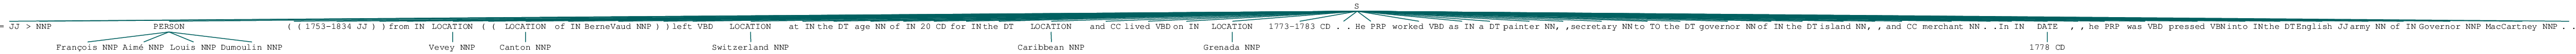

In [12]:
tree_text = stanford_tree(bio_text)
tree_text

In [14]:
# Function imported from 
# https://pythonprogramming.net/using-bio-tags-create-named-entity-lists/?completed=/testing-stanford-ner-taggers-for-speed/

# Parse named entities from tree
def structure_ne(ne_tree):
	ne = []
	for subtree in ne_tree:
		if type(subtree) == Tree: # If subtree is a noun chunk, i.e. NE != "O"
			ne_label = subtree.label()
			ne_string = " ".join([token for token, pos in subtree.leaves()])
			ne.append((ne_string, ne_label))
		else:
			ne_label = 'O'
			ne_string = subtree[0]
			ne.append((ne_string, ne_label))           
	return ne

In [15]:
clean_ne = structure_ne(tree_text)
clean_ne

[('=', 'O'),
 ('>', 'O'),
 ('François Aimé Louis Dumoulin', 'PERSON'),
 ('(', 'O'),
 ('1753-1834', 'O'),
 (')', 'O'),
 ('from', 'O'),
 ('Vevey', 'LOCATION'),
 ('(', 'O'),
 ('Canton', 'LOCATION'),
 ('of', 'O'),
 ('BerneVaud', 'O'),
 (')', 'O'),
 ('left', 'O'),
 ('Switzerland', 'LOCATION'),
 ('at', 'O'),
 ('the', 'O'),
 ('age', 'O'),
 ('of', 'O'),
 ('20', 'O'),
 ('for', 'O'),
 ('the', 'O'),
 ('Caribbean', 'LOCATION'),
 ('and', 'O'),
 ('lived', 'O'),
 ('on', 'O'),
 ('Grenada', 'LOCATION'),
 ('1773–1783', 'O'),
 ('.', 'O'),
 ('He', 'O'),
 ('worked', 'O'),
 ('as', 'O'),
 ('a', 'O'),
 ('painter', 'O'),
 (',', 'O'),
 ('secretary', 'O'),
 ('to', 'O'),
 ('the', 'O'),
 ('governor', 'O'),
 ('of', 'O'),
 ('the', 'O'),
 ('island', 'O'),
 (',', 'O'),
 ('and', 'O'),
 ('merchant', 'O'),
 ('.', 'O'),
 ('In', 'O'),
 ('1778', 'DATE'),
 (',', 'O'),
 ('he', 'O'),
 ('was', 'O'),
 ('pressed', 'O'),
 ('into', 'O'),
 ('the', 'O'),
 ('English', 'O'),
 ('army', 'O'),
 ('of', 'O'),
 ('Governor', 'O'),
 ('MacCartn

In [97]:
def ner_text(text):
    '''
    Input: One text, here one entry from the CCA 
    Output: Text with NER tags (and grouped entitites when necessary)
    '''
    tokenized_text = word_tokenize(text)
    classified_text = st.tag(tokenized_text)
    bio_text = bio_tagger(classified_text)
    tree_text = stanford_tree(bio_text)
    ner_item = structure_ne(tree_text)
    return ner_item

#### Helper for text and tags separation from NER 

In [103]:
def text_and_tags(item):
    '''
    Input : item with bothe text and tags
    Output : text and tags separated 
    Requirements : -
    Description : Separation of 
    '''
    #Default
    schema1 = False
    s1item_JSON = None
    #Separate text and tags
    text = [x[0] for x in item]
    tags = [x[1] for x in item]
    return text,tags

## Schemas

We recognize two differents schemas.  
Schema I:  
  **Name** (*date*) from *city*   
Schema II:   
 In (*date*), **Name** from *city*   

We use this information to organize the retrieval, namely we are going to identify PERSON tag as an indicator for for name and from as indicator of LOCATION. Then we will process the string  before, in between and after the indicators.

## Origin Location

 ### Origin location retrieval 

In [98]:
def origin_location_index(text,tags):
    '''
    Input : text and ner tags
    Output : index for origin location position or -1 if no origin location found 
    Requirements : -
    Description : The origin location is search according to schema 1 and 2 just after the word 'from' and retrieved if found 
    '''
    #The origin location can be found, according to schema 1 and 2 also be just after the 'from'...
 
    try:
        #Case 1: 1 word origin location
        origin_Index_method1 = text.index('from')
        origin_1 = text[origin_Index_method1+1]
        #Case 2: 2 words origin location, e.g. Le Locle 
        #print('First letter' + text[origin_Index_method1+2][0])
        if (text[origin_Index_method1+2][0]).isupper() : 
            origin_1 = origin_1 +' '+ text[origin_Index_method1+2]
        #Case 3: the City of Location, e.g. the City of Geneva
        if ((text[origin_Index_method1+2]) == 'City') or  ((text[origin_Index_method1+2]) == 'Canton'): 
            origin_1 = text[origin_Index_method1+4]
        #print('The origin index using from gives origin as :' + origin_1)
    except ValueError:
        #print("Item does not contain any FROM string")
        #print(text)    
        origin_1 = -1 #default
        origin_Index_method1 = -1
        
    return origin_Index_method1,origin_1

### Origin location accuracy (with additional database for Swiss cities)

#### Additional dataset for Swiss cities list

In [18]:
#Import additional dataset
PATH_CITIES = './data/worldcities.csv'
cities_df = pd.read_csv(PATH_CITIES)  

In [19]:
cities_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41001 entries, 0 to 41000
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   city        41001 non-null  object 
 1   city_ascii  41001 non-null  object 
 2   lat         41001 non-null  float64
 3   lng         41001 non-null  float64
 4   country     41001 non-null  object 
 5   iso2        40970 non-null  object 
 6   iso3        41001 non-null  object 
 7   admin_name  40902 non-null  object 
 8   capital     9483 non-null   object 
 9   population  40263 non-null  float64
 10  id          41001 non-null  int64  
dtypes: float64(3), int64(1), object(7)
memory usage: 3.4+ MB


In [20]:
# Select Swiss cities
swiss_cities_raw = cities_df[cities_df.country == 'Switzerland']

In [99]:
# Select unique names from columns relative to cities' name 
all_city = swiss_cities_raw['city'].unique()
all_city_ascii = swiss_cities_raw['city_ascii'].unique()
swiss_cities = set(all_city).intersection(all_city_ascii)
#name in the dataset are in their origin language
#additional entries 
swiss_cities.add('St.Gallen')
swiss_cities.add('Neuchâtel')
swiss_cities.add('Bâle')
swiss_cities.remove('Bern')
swiss_cities.add('Berne') #as Bern is in Bern.e it will work for both
#swiss_cities

#### Accuracy of origin location 

In [130]:
def origin_confidence(text,swiss_cities):
    '''
    Input : item text and list of all swiss cities
    Output : percentage accucary 
    Requirements : -
    Description : Each city from the list of swiss cities in serach for in the text. The number of cities found is counted. The accuracy is the invesrse of cities found. 
    '''
    #we will check how many swiss cities are in the text
    accuracy = 0
    cities = 0
    for city in swiss_cities:
        if (city) in text: #the space is here to guarantee that bern and berne are not counted twice
            #print(city)
            cities+=1
    #the accuracy is the citiy over all possibilities
    if (cities != 0) : accuracy = 1/cities * 100
    return "{0:.2f}".format(accuracy)

In [23]:
# n= 80 
# origin_confidence(text_items[n],swiss_cities)

In [101]:
# If we use the swiss cities list to retrieve without any scheme it doesnt increase the performance..
# Notes 
# - _St.Gallen_ is not recognized because of missing space
# - _Rougemont_
# - _Saint-Aubin_
# - _Au_ is recognized abusively
# - _Neuchâtel_ is no recognize because in Frence (Neuenhof)
# - _Zurich_ is not recognized because it is in French (missing ü)
# - _Bâle_ is not recognized because in French (Basel)

## Colonial location

The colonial location is found by using the TOC index, appended earlier to the text item . 

In [102]:
def colonial_location(text,tocList) :
    '''
    Input : item text and table of contents list
    Output : name of the colonial location 
    Requirements : - 
    Description : The function match the index with the toc list entries
    '''
    #TOC section number
    tocFromText = text[len(text)-1]#the last item is the TOC entry 
    #print(tocFromText)
    
    # only TOC section numbers
    tocListIndex = [x[0] for x in tocList]
    
    # find position of TOC section number in toclist section numbers
    index = tocListIndex.index(tocFromText)
    
    # use position to retrieve location name 
    colonialLoc = tocList[index][1]
    
    return colonialLoc 

Note that there isn't any confidence level for this property as it comes directly from the author and is unambiguous.


## Person name

In [107]:
def person_index(text,tags):
    '''
    Input : text and tages separate
    Output : the index of the person name in the text (-1 if no 'PERSON' tag)
    Requirements : -
    Description : This functions find the position of the PERSON tag and return -1
    '''
    ##--Start and end of piece of interest, i.e. ...'PERSON'.....'LOCATION'--##
    try:
        person_Index = tags.index('PERSON')
        #print("Item does contain a PERSON value"+str(text[person_Index]))
    except ValueError:
        person_Index = -1 #default
        #print("Item does not contain a PERSON value")
    return person_Index

## Activities

In [111]:
def colonial_activites(text):
    '''
    Input : text
    Output : list of colonial activities found in the text
    Requirements : -
    Description : 6 categories are defined manually by a sequence of keywords. Keywords are used to find which categories are present in the text. 
    '''
    # Colonial activities
    # goods = ['cotton', 'indigo', 'sugar', 'tobacco', 'textile']
    trading = ['company', 'companies', 'merchants', 'merchant']
    military = ['soldier','captain','lieutenant','commander','regiment', 'rebellion', 'troops']
    plantation = ['plantation', 'plantations']
    slave_trade = ['slave ship', 'slave-ship']
    slave_owner = ['slaves', 'slave', 'slave-owner']
    racist = ['racism', 'racist', 'races']
    result = []
    fam_idx = -1
    fam = False
    if 'family' in text:
        fam_idx = text.index('family')
        fam = True
        #print(fam_idx)
    for i, word in enumerate(text):
        if word in trading:
            idx = i
            #print(i)
            if not fam: # check if it's from a merchant family 
                result.append('trading')
            elif abs(fam_idx - i) > 5:
                result.append('trading')
        if word in military:
            result.append('military')
        if word in plantation:
            idx = i
            result.append('plantation owner')
        if word in slave_trade:
            result.append('slave trade')
        if word in slave_owner:
            result.append('slave owner')
        if word in racist:
            result.append('racist')

    return None if len(result) == 0 else tuple(set(result))

## Date

In [63]:
def date(text,tags,person_Index,origin_Index_method1):
    '''
    Input : 
    Output : 
    Requirements : 
    Description : 
    '''
    #SCHEMA 2
    #In YEAR' test 
    inYear = (text[2] == 'In') and (len(text[3]) == 4) and (text[3].isdigit())
    #print('This item looks like an schema 2 item '+str(inYear) + str(text[2:4]))
    if inYear : 
        date = text[3]
        return date
    
    else :
    #SCHEMA 1
    #(date)
        #Define part in between PER and LOC tags
        ner_middle = item[person_Index+1:origin_Index_method1]
        text_middle = text[person_Index+1:origin_Index_method1]

        #Parenthesis test
        try:
            par1_Index = text_middle.index('(')
        except ValueError:
            par1_Index = -1 #default

        try:
            par2_Index = text_middle.index(')')
        except ValueError:
            par2_Index = -1 #default

        #If there are parenthesis
        if par1_Index < par2_Index and par2_Index >= 0 and par1_Index >= 0 :
            date_par = text_middle[par1_Index+1:par2_Index]
            date = str(date_par[0])
            return date
        else :
            return None

### Confidence levels functions

In [112]:
def accuracy(text,tags,swiss_cities):
    '''
    Input : text, tags and the list of swiss cities
    Output :  list of accuracy percentage for date, person and origin 
    Requirements : -
    Description : The accuracy or confidence level is measured based on the amount of possibly contradictory information in the text
    '''
    #activity_occurences = ...
    #acc_activity = 1/activity_occurences * 100
    try :
        acc_date = "{0:.2f}".format(1/tags.count('DATE') * 100)
    except: 
        acc_date = 100
    try :    
        acc_person = "{0:.2f}".format(1/tags.count('PERSON') * 100)
    except: 
        acc_person = 100
    
    acc_origin = origin_confidence(text,swiss_cities)
    
    return [acc_date,acc_person,acc_origin]

## Main call

The functions created above are called on each item retrieved from the primary sources and saved as dictionaries.

In [134]:
#empty list 
jsonList= []

#counters
i = 0
s1 = 0
nothing = 0 
disordered = 0
no_person = 0
no_location = 0

#main loop on items
for item in text_items[10:50]:
        
        #NER
        nerItem = ner_text(item)
        text,tags = text_and_tags(nerItem)
        
        #Indices retrieval for schema identifications
        personIndex = person_index(text,tags)
        originIndex,origin = origin_location_index(text,tags) 

        #If no person and no location 
        if (personIndex < 0) and (originIndex <0):
            #print('There isnt any information to retrieve')
            nothing +=1
            continue
            
        #If no person but location 
        if (personIndex < 0) and (originIndex >0):
            #print('There isnt any information to retrieve')
            no_person +=1
            continue
            
        #If person and location but wrong order
        if (personIndex > 0) and (originIndex >0) and (personIndex > originIndex) :
            #print('The information arent following the expected schemas')
            disordered +=1
            continue
            
        #From here on there is a person thus we can retrieve some information
        
        # PERSON retrieval 
        person = text[personIndex]
        
        # COLONIAL LOCATION retrieval 
        colonialLoc = colonial_location(text,tocList)
        
        # FULL ENTRY  without location index
        item_clean = item[0:(len(item)-3)]    
        
        # ACTIVITIES retrieval
        activities = colonial_activites(text)
        
        
        # ORIGIN retrieval 
        origin = origin 
        
        # DATE retrieval 
        # For the date the schema is differente
            
        #If person and no location 
        if (personIndex > 0) and (originIndex <0):
            #we look for date in the 15 next wwords
            dummy_origin_index = personIndex + 15
            
            #Retrieve date according to schema1 or schema2 if no date then None
            dateValue = date(text,tags,personIndex,dummy_origin_index)
            
            if ('Geneva' in text) :
                origin = 'Geneva'
                
            if ('Neuchâtel' in text) :
                origin = 'Neuchâtel'
            no_location +=1
                
     
        #If SCHEMAS I or II (person and location and right order)
        if (personIndex > 0) and (originIndex >0)  and (personIndex < originIndex) :

                # Retrieve date according to schema1 or schema2 if no date then None
                dateValue = date(text,tags,personIndex,originIndex)


        # Calculate accuracy 
        [acc_date,acc_person,acc_origin] = accuracy(text,tags,swiss_cities)

        # Create a JSON dictionary
        item_JSON = {
            'person' : person,
            'date': dateValue,
            'origin': origin,
            'colonial_Location': colonialLoc,
            'confidence_date':acc_date,
            'confidence_person':acc_person,
            'confidence_origin':acc_origin,
            'activities': activities,
            'whole_entry': item_clean
            #'field':NA
        }
        jsonList.append(item_JSON)
        
       
            
        if (origin_info[0] == -1) : 
            origin_iter = origin_iter +1
            #print('This item doesnt follow one of the two scheme because it doesnt have a person or location in the right order')
        #print(item_JSON)

In [135]:
print(f'There are {len(text_items)} text items from the division of the initial page')
print(f'There are {len(jsonList)} entries after extraction of text of interest')

There are 464 text items from the division of the initial page
There are 32 entries after extraction of text of interest


In [136]:
print(f'There area {nothing} entries where neither the person nor the location could be defined.\nThere are {disordered} entries with person and location in the wrong order.\nThere are {no_person} entries with no person defined.\nThere are {no_location} entries with no location defined.\n')

There area 0 entries where neither the person nor the location could be defined.
There are 5 entries with person and location in the wrong order.
There are 3 entries with no person defined.
There are 4 entries with no location defined.



In [138]:
#jsonList

Reasons for the decrease of entries:

## Some statistics

In [110]:
len(text_items) - (person_iter+origin_iter+len(jsonList))

117

### Accuracy level


In [1638]:
tagstmp = text_items[35]
nerItem = ner_text(tmp)
tags = text_and_tags(nerItem)[1]

The classification accuracy is calculated based on the amount of complexity of the item. A very simple item that will contains only one mention of an activity cannot be misclassified. On the other hand, if we have 5 activities mentioned the accuracy that we have selected the right information decreases. 
To encode this accuracy level, we calculate a precentage based on the attributes occurences. 

a = 1 / number_Of_Occurences * 100

For the activities atrributes the classification is only based on the type of information and doesn't follow any pattern, therefore in this case this method of calculating accuracy is  relevant.

If we use a similar approach for the other attributes this accuracy level is a lower bound of our accuracy, indeed we select date, person and origin location based on predefined pattern which helps us to select the right information. 

Finally for the colonial location we don't calculate an accuracy level as it is extracted directly from the corpus structure and thus cannot be misclassified.

## Date improvement

In [1639]:
for i in range(10):
    nerItem = ner_text(text_items[i])
    text,tags = text_and_tags(nerItem)
    person_Index =  personIndex = person_index(text,tags)
    origin_Index_method1 = origin_location_index(text,tags)[0] 
    dateValue = date(text_tags[0],text_tags[1],personIndex,origin_info[0])

def date(text,tags,person_Index,origin_Index_method1):
    #SCHEMA 2
    #In YEAR' test 
    inYear = (text[2] == 'In') and (len(text[3]) == 4) and (text[3].isdigit())
    #print('This item looks like an schema 2 item '+str(inYear) + str(text[2:4]))
    if inYear : 
        date = text[3]
        print('With schema 2 we have date : ')
        return date
    
    else :
    #SCHEMA 1
    #(date)
        #Define part in between PER and LOC tags
        ner_middle = item[person_Index+1:origin_Index_method1]
        text_middle = text[person_Index+1:origin_Index_method1]

        #Parenthesis test
        try:
            par1_Index = text_middle.index('(')
        except ValueError:
            par1_Index = -1 #default

        try:
            par2_Index = text_middle.index(')')
        except ValueError:
            par2_Index = -1 #default

        #If there are parenthesis
        if par1_Index < par2_Index and par2_Index >= 0 and par1_Index >= 0 :
            date_par = text_middle[par1_Index+1:par2_Index]
            date = str(date_par[0])
            print('With schema 1 we have date : ')
            return date
        else :
            return None

## Save 

In [111]:
import json 
a_file = open("from_caricom.json", "w")
a_file = json.dump(jsonList, a_file) 

# Load 

In [112]:
import json 
a_file = open("from_caricom.json", "r")
jsonList = json.load(a_file)

In [113]:
#jsonList

## From JSONs to Dataframe

In [114]:
#transform JSON list into a dataframe 
caricomDataRaw = pd.json_normalize(jsonList)

In [115]:
#caricomDataRaw['origin']

In [116]:
tot = len(caricomDataRaw['origin'])
filled = len(caricomDataRaw[caricomDataRaw['origin'].isnull()])
print(f'We have {tot} entries, and {filled} empty entries')

We have 347 entries, and 0 empty entries


In [117]:
#caricomDataRaw['origin']

## Cleaning
- Remove all the duplicates
- If some entries have the samed person we need to merge or remove one of the entry...no_correspondance

In [118]:
# #options for dataframe visualization 
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
# pd.set_option('display.width', None)
# pd.set_option('display.max_colwidth', -1)

In [119]:
import re 
caricomDataRaw.drop_duplicates(inplace = True)
caricomDataRaw['person'] = caricomDataRaw['person'].apply(lambda x: re.sub('[^A-Za-z ]+', '', x))

TypeError: unhashable type: 'list'

In [120]:
#caricomDataRaw[['person','date','origin','colonial_Location']].iloc[1:100]

## Geolocalisation

### Load

In [121]:
import geonamescache
# countries
gc = geonamescache.GeonamesCache()
countries = gc.get_countries_by_names()
# cities
# For cities we don't need to load a set we can directly use gc.get_cities_by_name(name) function

### Geoinformation for colonial location 
Colonial locations are mostly countries. 

In [122]:
countries_raw = caricomDataRaw['colonial_Location'].unique()

In [123]:
countries_raw

array(['Antigua and Barbuda', 'Barbados', 'Dominica', 'Grenada', 'Guyana',
       'Haiti', 'Jamaica', 'Montserrat', 'Cuba', 'Netherlands Antilles',
       'French West Indies', 'Danish West Indies', 'Venezuela',
       'Bermudas', 'Alabama', 'Arkansas', 'California', 'Carolinas',
       'Florida', 'Georgia', 'Louisiana', 'Mississippi', 'Brazil',
       'Southern Africa', 'East Indies', 'Switzerland'], dtype=object)

#### United States

In [124]:
us_states = gc.get_us_states()
#us_states

In [125]:
us_states_dic = []
for i in range(len(list(us_states.keys())[0:51])):
    key = list(us_states.keys())[i]
    #print(key)
    all_inf = us_states[str(key)]
    name = all_inf['name']
    us_states_dic.append([name,key])
    #print(name)
#us_states_dic

In [126]:
### capital 
capital_dic={
    'Alabama': 'Montgomery',
    'Alaska': 'Juneau',
    'Arizona':'Phoenix',
    'Arkansas':'Little Rock',
    'California': 'Sacramento',
    'Colorado':'Denver',
    'Connecticut':'Hartford',
    'Delaware':'Dover',
    'Florida': 'Tallahassee',
    'Georgia': 'Atlanta',
    'Hawaii': 'Honolulu',
    'Idaho': 'Boise',
    'Illinios': 'Springfield',
    'Indiana': 'Indianapolis',
    'Iowa': 'Des Monies',
    'Kansas': 'Topeka',
    'Kentucky': 'Frankfort',
    'Louisiana': 'Baton Rouge',
    'Maine': 'Augusta',
    'Maryland': 'Annapolis',
    'Massachusetts': 'Boston',
    'Michigan': 'Lansing',
    'Minnesota': 'St. Paul',
    'Mississippi': 'Jackson',
    'Missouri': 'Jefferson City',
    'Montana': 'Helena',
    'Nebraska': 'Lincoln',
    'Neveda': 'Carson City',
    'New Hampshire': 'Concord',
    'New Jersey': 'Trenton',
    'New Mexico': 'Santa Fe',
    'New York': 'Albany',
    'North Carolina': 'Raleigh',
    'North Dakota': 'Bismarck',
    'Ohio': 'Columbus',
    'Oklahoma': 'Oklahoma City',
    'Oregon': 'Salem',
    'Pennsylvania': 'Harrisburg',
    'Rhoda Island': 'Providence',
    'South Carolina': 'Columbia',
    'South Dakoda': 'Pierre',
    'Tennessee': 'Nashville',
    'Texas': 'Austin',
    'Utah': 'Salt Lake City',
    'Vermont': 'Montpelier',
    'Virginia': 'Richmond',
    'Washington': 'Olympia',
    'West Virginia': 'Charleston',
    'Wisconsin': 'Madison',
    'Wyoming': 'Cheyenne'  
}


In [127]:
countries_clean =[]
only_names = [x[0] for x in us_states_dic]
for country in countries_raw:
# get rid of numbers in string 
    country = re.sub('[^A-Za-z ]+', '', country)
    countries_clean.append(country)
countries_clean

#Create a dictionary with geo information of countries of interest
countries_geo_dict = []
for countryName in countries_clean:
    one_word = countryName.split()[0]
    
    try :
        country = countries[one_word]
        countries_geo_dict.append(country)
    except : 
        try : 
            country = countries[countryName]
            countries_geo_dict.append(country)
        except :
            #print('Not a country')
            country = None
            countries_geo_dict.append(country)
#For usstates
    try :
        index = only_names.index(countryName) 
        countryInitial = us_states_dic[index][1]
        country = us_states[countryInitial]
        countries_geo_dict.append(country)
    except :
        continue
            
#add countires for regional appelation 
 # We havae 6 entries in the dataframe that must be mapped to another geoname

# Netherlands Antilles, for now we will map this to aruba (already in the dataset)
# French West Indies for now we will map this to Guadeloupe
country = countries['Guadeloupe']
countries_geo_dict.append(country)
#'Danish West Indies for now we will map to Antiguaand bArbada(already in the dataset)
#'Southern Africa', for now we will map to South Africa
country = countries['South Africa']
countries_geo_dict.append(country)
# East Indies' is maped to Indonesia
country = countries['Indonesia']
countries_geo_dict.append(country)


    #append sublocation 
    #sublocationList = ['Berbice','Demerara','Demerary','Essequibo',
                       #'Aruba','Bonaire','Curaçao','St. Eustacius','Guadeloupe','Martinique','St. John', 'St. Croix','St. Thomas']
        
    # for location in sublocationList:
    #     try : 
    #         country = countries[location]
    #         countries_geo_dict.append(country)
    #     except : 
    #         country = None
    #         countries_geo_dict.append(country)

#countries_clean
# to remove None values in list
countries_geo_dict_final = []
for val in countries_geo_dict:
    if val != None :
        countries_geo_dict_final.append(val)       

In [128]:
#transform JSON list into a dataframe 
colonial_countries = pd.json_normalize(countries_geo_dict_final)
colonial_countries.drop_duplicates(subset=['name'],keep='last')

,geonameid,name,iso,iso3,isonumeric,fips,continentcode,capital,areakm2,population,tld,currencycode,currencyname,phone,postalcoderegex,languages,neighbours,code
0,3576396,Antigua and Barbuda,AG,ATG,28.0,AC,NA,St. John's,443.0,86754.0,.ag,XCD,Dollar,+1-268,,en-AG,,NaN
1,3374084,Barbados,BB,BRB,52.0,BB,NA,Bridgetown,431.0,285653.0,.bb,BBD,Dollar,+1-246,^(?:BB)*(\d{5})$,en-BB,,NaN
2,3575830,Dominica,DM,DMA,212.0,DO,NA,Roseau,754.0,72813.0,.dm,XCD,Dollar,+1-767,,en-DM,,NaN
3,3580239,Grenada,GD,GRD,308.0,GJ,NA,St. George's,344.0,107818.0,.gd,XCD,Dollar,+1-473,,en-GD,,NaN
4,3378535,Guyana,GY,GUY,328.0,GY,SA,Georgetown,214970.0,748486.0,.gy,GYD,Dollar,592,,en-GY,"SR,BR,VE",NaN
5,3723988,Haiti,HT,HTI,332.0,HA,NA,Port-au-Prince,27750.0,9648924.0,.ht,HTG,Gourde,509,^(?:HT)*(\d{4})$,"ht,fr-HT",DO,NaN
6,3489940,Jamaica,JM,JAM,388.0,JM,NA,Kingston,10991.0,2847232.0,.jm,JMD,Dollar,+1-876,,en-JM,,NaN
7,3578097,Montserrat,MS,MSR,500.0,MH,NA,Plymouth,102.0,9341.0,.ms,XCD,Dollar,+1-664,,en-MS,,NaN
8,3562981,Cuba,CU,CUB,192.0,CU,NA,Havana,110860.0,11423000.0,.cu,CUP,Peso,53,^(?:CP)*(\d{5})$,es-CU,US,NaN
9,2750405,Netherlands,NL,NLD,528.0,NL,EU,Amsterdam,41526.0,16645000.0,.nl,EUR,Euro,31,^(\d{4}[A-Z]{2})$,"nl-NL,fy-NL","DE,BE",NaN


In [129]:
#add capitals for us states
for name in colonial_countries['name'] :
    if name in only_names: #only names is the list of US states
        print(f'We have a us state: {name}')
        capital = capital_dic[name]
        print(f'The capital is {capital}')
        #df = colonial_countries.loc[colonial_countries['name'] == name]
        colonial_countries.loc[(colonial_countries['name'] == name),'capital']=capital
        #colonial_countries.insert(2,'capital', capital)
colonial_countries

We have a us state: Alabama
The capital is Montgomery
We have a us state: Arkansas
The capital is Little Rock
We have a us state: California
The capital is Sacramento
We have a us state: Florida
The capital is Tallahassee
We have a us state: Georgia
The capital is Atlanta
We have a us state: Georgia
The capital is Atlanta
We have a us state: Louisiana
The capital is Baton Rouge
We have a us state: Mississippi
The capital is Jackson


,geonameid,name,iso,iso3,isonumeric,fips,continentcode,capital,areakm2,population,tld,currencycode,currencyname,phone,postalcoderegex,languages,neighbours,code
0,3576396,Antigua and Barbuda,AG,ATG,28.0,AC,NA,St. John's,443.0,86754.0,.ag,XCD,Dollar,+1-268,,en-AG,,NaN
1,3374084,Barbados,BB,BRB,52.0,BB,NA,Bridgetown,431.0,285653.0,.bb,BBD,Dollar,+1-246,^(?:BB)*(\d{5})$,en-BB,,NaN
2,3575830,Dominica,DM,DMA,212.0,DO,NA,Roseau,754.0,72813.0,.dm,XCD,Dollar,+1-767,,en-DM,,NaN
3,3580239,Grenada,GD,GRD,308.0,GJ,NA,St. George's,344.0,107818.0,.gd,XCD,Dollar,+1-473,,en-GD,,NaN
4,3378535,Guyana,GY,GUY,328.0,GY,SA,Georgetown,214970.0,748486.0,.gy,GYD,Dollar,592,,en-GY,"SR,BR,VE",NaN
5,3723988,Haiti,HT,HTI,332.0,HA,NA,Port-au-Prince,27750.0,9648924.0,.ht,HTG,Gourde,509,^(?:HT)*(\d{4})$,"ht,fr-HT",DO,NaN
6,3489940,Jamaica,JM,JAM,388.0,JM,NA,Kingston,10991.0,2847232.0,.jm,JMD,Dollar,+1-876,,en-JM,,NaN
7,3578097,Montserrat,MS,MSR,500.0,MH,NA,Plymouth,102.0,9341.0,.ms,XCD,Dollar,+1-664,,en-MS,,NaN
8,3562981,Cuba,CU,CUB,192.0,CU,NA,Havana,110860.0,11423000.0,.cu,CUP,Peso,53,^(?:CP)*(\d{5})$,es-CU,US,NaN
9,2750405,Netherlands,NL,NLD,528.0,NL,EU,Amsterdam,41526.0,16645000.0,.nl,EUR,Euro,31,^(\d{4}[A-Z]{2})$,"nl-NL,fy-NL","DE,BE",NaN


### Add for each entry in dataframe a geoname id

In [130]:
uniqueColLoc= caricomDataRaw['colonial_Location'].unique()
lenColLocDF = len(uniqueColLoc)
print(f'There are {lenColLocDF} unique entries in the dataframe for {len(colonial_countries)} entries in the geo infromation')

There are 26 unique entries in the dataframe for 24 entries in the geo infromation


### Merge, geoname, geoid column

In [131]:
def to_tmp_colonial(colonial_Location):
    # We have 6 entries in the dataframe that must be mapped to another geoname
    # Netherlands Antilles, for now we will map this to aruba
    # French West Indies for now we will map this to Guadeloupe
    #'Danish West Indies for now we will map to Antiguaand bArbada
    #'North America' for now wi wil map to US
    #'Southern Africa', for now we will map to South Africa
    # East Indies' is maped to Indonesia

    listToModify = ['Netherlands Antilles','French West Indies','Danish West Indies','North America','Southern Africa', 'East Indies']
    listReplacement= ['Aruba','Guadeloupe','Antigua and Barbuda','United States','South Africa','Indonesia']
    if colonial_Location in listToModify:
        index = listToModify.index(colonial_Location)
        colonial_Location =  listReplacement[index]
    return colonial_Location 

In [132]:
caricomDataRaw['tmp_colonial'] =caricomDataRaw['colonial_Location'] .apply(lambda x : to_tmp_colonial(x)) 

In [133]:
colonial_countries.head()

,geonameid,name,iso,iso3,isonumeric,fips,continentcode,capital,areakm2,population,tld,currencycode,currencyname,phone,postalcoderegex,languages,neighbours,code
0,3576396,Antigua and Barbuda,AG,ATG,28.0,AC,NA,St. John's,443.0,86754.0,.ag,XCD,Dollar,+1-268,,en-AG,,NaN
1,3374084,Barbados,BB,BRB,52.0,BB,NA,Bridgetown,431.0,285653.0,.bb,BBD,Dollar,+1-246,^(?:BB)*(\d{5})$,en-BB,,NaN
2,3575830,Dominica,DM,DMA,212.0,DO,NA,Roseau,754.0,72813.0,.dm,XCD,Dollar,+1-767,,en-DM,,NaN
3,3580239,Grenada,GD,GRD,308.0,GJ,NA,St. George's,344.0,107818.0,.gd,XCD,Dollar,+1-473,,en-GD,,NaN
4,3378535,Guyana,GY,GUY,328.0,GY,SA,Georgetown,214970.0,748486.0,.gy,GYD,Dollar,592,,en-GY,"SR,BR,VE",NaN


In [134]:
from geonamescache.mappers import country
mapper = country(from_key='name', to_key='iso')
def getCapital_coo(country,capital_Name):
    
    if capital_Name == 'Berne':
        capital_Name = 'Bern'
    if capital_Name == 'Brasilia':
        capital_Name = 'Brasília' 
    if capital_Name == 'St. George\'s':    
        capital_Name = 'Saint George\'s'
        
    lat = 'None'
    lon = 'None'
    all_info = gc.search_cities(capital_Name)
    countrycode = mapper(country) #get country code
    #default 
    origin_geo = all_info[0] 
    for sub in all_info :
        if sub['countrycode'] == countrycode:
            origin_geo = sub
   
    if len(origin_geo)>0:
#         key_id = list(all_info[0].keys())[0]
#         origin_geo = all_info[0].get(key_id, {})
        lat = origin_geo['latitude']
        lon = origin_geo['longitude']
        
    return lat,lon

In [135]:
#Example
getCapital_coo('Jamaica','Kingston')

(17.99702, -76.79358)

In [136]:
#df['col_3'] = df.apply(lambda x: f(x.col_1, x.col_2), axis=1)

In [137]:
colonial_countries.head(1)

,geonameid,name,iso,iso3,isonumeric,fips,continentcode,capital,areakm2,population,tld,currencycode,currencyname,phone,postalcoderegex,languages,neighbours,code
0,3576396,Antigua and Barbuda,AG,ATG,28.0,AC,NA,St. John's,443.0,86754.0,.ag,XCD,Dollar,+1-268,,en-AG,,NaN


In [138]:
colonial_countries['latitude'] = colonial_countries.apply(lambda x : getCapital_coo(x['name'],x['capital'])[0],axis=1)
colonial_countries['longitude'] = colonial_countries.apply(lambda x : getCapital_coo(x['name'],x['capital'])[1],axis=1)
colonial_countries

,geonameid,name,iso,iso3,isonumeric,fips,continentcode,capital,areakm2,population,tld,currencycode,currencyname,phone,postalcoderegex,languages,neighbours,code,latitude,longitude
0,3576396,Antigua and Barbuda,AG,ATG,28.0,AC,NA,St. John's,443.0,86754.0,.ag,XCD,Dollar,+1-268,,en-AG,,NaN,17.12096,-61.84329
1,3374084,Barbados,BB,BRB,52.0,BB,NA,Bridgetown,431.0,285653.0,.bb,BBD,Dollar,+1-246,^(?:BB)*(\d{5})$,en-BB,,NaN,13.10732,-59.62021
2,3575830,Dominica,DM,DMA,212.0,DO,NA,Roseau,754.0,72813.0,.dm,XCD,Dollar,+1-767,,en-DM,,NaN,15.30174,-61.38808
3,3580239,Grenada,GD,GRD,308.0,GJ,NA,St. George's,344.0,107818.0,.gd,XCD,Dollar,+1-473,,en-GD,,NaN,12.05288,-61.75226
4,3378535,Guyana,GY,GUY,328.0,GY,SA,Georgetown,214970.0,748486.0,.gy,GYD,Dollar,592,,en-GY,"SR,BR,VE",NaN,6.80448,-58.15527
5,3723988,Haiti,HT,HTI,332.0,HA,NA,Port-au-Prince,27750.0,9648924.0,.ht,HTG,Gourde,509,^(?:HT)*(\d{4})$,"ht,fr-HT",DO,NaN,18.54349,-72.33881
6,3489940,Jamaica,JM,JAM,388.0,JM,NA,Kingston,10991.0,2847232.0,.jm,JMD,Dollar,+1-876,,en-JM,,NaN,17.99702,-76.79358
7,3578097,Montserrat,MS,MSR,500.0,MH,NA,Plymouth,102.0,9341.0,.ms,XCD,Dollar,+1-664,,en-MS,,NaN,16.70555,-62.21292
8,3562981,Cuba,CU,CUB,192.0,CU,NA,Havana,110860.0,11423000.0,.cu,CUP,Peso,53,^(?:CP)*(\d{5})$,es-CU,US,NaN,23.13302,-82.38304
9,2750405,Netherlands,NL,NLD,528.0,NL,EU,Amsterdam,41526.0,16645000.0,.nl,EUR,Euro,31,^(\d{4}[A-Z]{2})$,"nl-NL,fy-NL","DE,BE",NaN,52.37403,4.88969


In [139]:
#prepare the colonial countries dataframes to be added 
colonial_countries_for_merge = colonial_countries[['geonameid','name','capital','latitude','longitude']]
colonial_countries_for_merge = colonial_countries_for_merge.rename(columns={"geonameid": "col_loc_geonameid",
                                                                            "name": "col_loc_geo_name",
                                                                            'capital':'col_capital',
                                                                            'latitude':"col_latitude",
                                                                            'longitude':"col_longitude"})

In [140]:
caricom_col_loc = caricomDataRaw.merge(colonial_countries_for_merge, left_on='tmp_colonial', right_on='col_loc_geo_name')

In [141]:
caricom_col_loc = caricom_col_loc.drop(columns = ['tmp_colonial'])

In [142]:
#caricom_col_loc

### Geoinformation for location of origin 
In the origin location we have mostly cities and region, if the specific places doesn't correspond to any know cities we use Switzerland as a general indicator.

In [143]:
#cleaning of origin 
def clean_origin(origin): 
    if origin == None:
        return None
    #remove parenthesis and everything that comes after it 
    try :
        start = origin.index('(')
    except : 
        start = len(origin)
    origin = origin[0:start]
    #print(origin)
    #remove digits and symbols
    origin = re.sub('[^A-Za-z -.]+','',origin)
   
    #split version
    o_split = origin.split()
    cleanOrigin = ''
    for split in o_split:
        #get rid of one letter 
        if len(split) <2:
            #print(split)
            split = ''
            #print(split)
        cleanOrigin = cleanOrigin+' '+split
        #print(cleanOrigin)
        cleanOrigin = cleanOrigin.strip()
    if cleanOrigin == 'St.Gallen':
        cleanOrigin = 'St. Gallen'
    return cleanOrigin 

In [144]:
caricom_col_loc['origin'] = caricom_col_loc['origin'].apply(lambda x : clean_origin(x))

In [145]:
origin_locs = caricom_col_loc['origin'].unique()
origin_locs
#len(origin_locs)

array(['Geneva', 'Zurich', 'Saint-Aubin', 'Bournens', 'Bourmens',
       'St. Gallen', '', 'Echallens', 'Schaffhausen', 'Obersimmental',
       'Ble', 'Noraz', 'Le Locle', 'the Valle de Joux', 'Rehetobel',
       'Brazil', 'Morges', 'Basel', 'Ropraz', 'Gourgy',
       'tropical West Africa', 'Huguenot', 'Martinique', 'Africa',
       'Neuchtel', 'Vevey', 'where', 'Lausanne', 'the', 'church',
       'Lelienburg', 'Brglen', 'Burgdorf', 'an Yverdon', 'Thurgau',
       'Treytorrens', 'his', 'Speicher', 'Walenstadt', 'Aarau',
       'La Tour-de-Peilz', 'Lutry', 'Murten', 'Switzerland',
       'La Rochelle', 'Versoix', 'Sonvillier', 'Schftland',
       'Saint-Domingue', 'trade', 'Berne', 'Hunziker', 'Solothurn',
       'Aargau', 'Dornach', 'Lucerne', 'Graubnden', 'Jamaica',
       'Rougement', 'Yverdon', 'Mtier', 'Winterthur', 'Biel',
       'Bischofszell', 'Unterseen BE', 'Couvet', 'Nantes', 'Fribourg',
       'the City of Berne', 'Saint-Saphorin', 'Saint-Lgier-La Chisaz',
       'the Swiss

In [146]:
#counters
found = 0 
no_correspondance = 0 
origin_geo_dic = []
#loop to fill with geo information for origin countries
for origin in origin_locs:
        #sanity check for empty entry
        if (origin != None) and (origin != ''):
            origin_geo_all = gc.search_cities(origin)
            
            #get the country of cities !MUST BE SWITERLAND
            #default 
#             for sub in origin_geo_all :
#                 if sub['countrycode'] == 'CH':
#                     origin_geo = sub
#                 else:
#                     origine_geo = origin_geo_all[0]
           # origine_geo = origin_geo_all[0]
            if len(origin_geo_all) > 0 :
                dict_geo = origin_geo_all[0]
                if(dict_geo['countrycode']=='CH'):
                    dict_geo['origin_as_found']=origin
                    #print(dict_geo)
                    found = found +1 
                    origin_geo_dic.append(dict_geo)
                    #print(f'There is a correspondance for {origin}')


print(f'There are {found} found')

There are 16 found


In [147]:
#origin_geo_dic

In [148]:
#transform JSON list into a dataframe 
origin_cities = pd.json_normalize(origin_geo_dic)
origin_cities = origin_cities[['origin_as_found','geonameid','name','latitude','longitude']]

In [149]:
origin_cities = origin_cities.drop_duplicates()
origin_cities = origin_cities.rename(columns={"geonameid": "origin_loc_geonameid", "name": "origin_geo_name",'latitude':"origin_latitude",'longitude':"origin_longitude"})

#### Geodata for origin locations final dataframe

In [150]:
origin_cities

,origin_as_found,origin_loc_geonameid,origin_geo_name,origin_latitude,origin_longitude
0,Geneva,2660646,Genève,46.20222,6.14569
1,Zurich,2657896,Zürich,47.36667,8.55000
2,St. Gallen,2658822,Sankt Gallen,47.42391,9.37477
3,Schaffhausen,2658761,Schaffhausen,47.69732,8.63493
4,Basel,2661604,Basel,47.55839,7.57327
5,Vevey,2658145,Vevey,46.46299,6.84345
6,Lausanne,2659994,Lausanne,46.51600,6.63282
7,Aarau,2661881,Aarau,47.39254,8.04422
8,Berne,2661552,Bern,46.94809,7.44744
9,Lucerne,2659811,Luzern,47.05048,8.30635


#### Merge

In [151]:
len(caricom_col_loc)

325

In [152]:
caricom_both_loc = caricom_col_loc.merge( origin_cities,how = 'outer', left_on='origin', right_on='origin_as_found')

In [153]:
#caricom_both_loc

In [154]:
origin_geo_all = gc.get_cities_by_name('Bern')[0]
keyId_bern = list(origin_geo_all.keys())[0]

In [155]:
import numpy as np 
caricom_both_loc['origin_geo_name'] = caricom_both_loc['origin_geo_name'].replace(np.nan, 'Bern')
caricom_both_loc['origin_loc_geonameid'] = caricom_both_loc['origin_loc_geonameid'].replace(np.nan,keyId_bern)

In [156]:
#this shows why we need to merge on the origin as found
#caricom_both_loc[caricom_both_loc['origin_as_found']=='Biel']

In [157]:
caricom_both_loc[['person','date','origin','colonial_Location','origin_as_found',
                  'col_loc_geonameid','col_loc_geo_name','col_capital','col_latitude',
                 'col_longitude','origin_loc_geonameid','origin_geo_name',
                  'origin_latitude','origin_longitude']]

,person,date,origin,colonial_Location,origin_as_found,col_loc_geonameid,col_loc_geo_name,col_capital,col_latitude,col_longitude,origin_loc_geonameid,origin_geo_name,origin_latitude,origin_longitude
0,Arthur Thellusson,None,Geneva,Antigua and Barbuda,Geneva,3576396,Antigua and Barbuda,St. John's,17.12096,-61.84329,2.66065e+06,Genève,46.20222,6.14569
1,Jamaica Kincaid,None,Geneva,Antigua and Barbuda,Geneva,3576396,Antigua and Barbuda,St. John's,17.12096,-61.84329,2.66065e+06,Genève,46.20222,6.14569
2,Henry Peschier,1781,Geneva,Antigua and Barbuda,Geneva,3576396,Antigua and Barbuda,St. John's,17.12096,-61.84329,2.66065e+06,Genève,46.20222,6.14569
3,Peter Thelluson,1767,Geneva,Barbados,Geneva,3374084,Barbados,Bridgetown,13.10732,-59.62021,2.66065e+06,Genève,46.20222,6.14569
4,Jean-Antoine Bertrand (,None,Geneva,Dominica,Geneva,3575830,Dominica,Roseau,15.30174,-61.38808,2.66065e+06,Genève,46.20222,6.14569
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320,Albert Maag,1899,danger,Switzerland,NaN,2658434,Switzerland,Berne,46.94809,7.44744,2661552,Bern,NaN,NaN
321,Henry Hotze,1833–1887,Rmlang,Switzerland,NaN,2658434,Switzerland,Berne,46.94809,7.44744,2661552,Bern,NaN,NaN
322,Peter Buser,2019,the Dominican Republic,Switzerland,NaN,2658434,Switzerland,Berne,46.94809,7.44744,2661552,Bern,NaN,NaN
323,Jost Bürgi,1552-1632,Lichtensteig,Switzerland,NaN,2658434,Switzerland,Berne,46.94809,7.44744,2661552,Bern,NaN,NaN


In [158]:
len(caricom_both_loc)

325

In [159]:
caricom_both_loc.origin_geo_name.unique()

array(['Genève', 'Zürich', 'Bern', 'Sankt Gallen', 'Schaffhausen',
       'Basel', 'Vevey', 'Lausanne', 'Aarau', 'Luzern',
       'Yverdon-les-Bains', 'Winterthur', 'Biel/Bienne', 'Fribourg',
       'Chur', 'Zug'], dtype=object)

## Dump DF 

In [160]:
caricom_both_loc.to_pickle("./caricom_with_geoid.pkl")

## Read pickle

In [105]:
unpickled_df = pd.read_pickle("./caricom_with_geoid.pkl")

In [1632]:
unpickled_df.head()

,person,date,origin,colonial_Location,confidence_date,confidence_person,confidence_origin,whole_entry,col_loc_geonameid,col_loc_geo_name,col_capital,col_latitude,col_longitude,origin_as_found,origin_loc_geonameid,origin_geo_name,origin_latitude,origin_longitude
0,Arthur Thellusson,None,None,Antigua and Barbuda,100.000000,25.0,33.333333,"=> Arthur Thellusson, son of Lord Rendlesham and grandson of Peter Thellusson, born into a Geneva banking family, who had bought the original Brodsworth Hall estate in South Yorkshire (GB) in 1790, married the daughter of Antigua slave owner Sir Christopher Bethell-Codrington.",3576396,Antigua and Barbuda,St. John's,47.56494,-52.70931,NaN,2661552,Bern,NaN,NaN
1,Jamaica Kincaid,None,None,Antigua and Barbuda,100.000000,100.0,100.000000,"=> In her book A Small Place (1988), the Antiguan writer Jamaica Kincaid indicts the Antiguan government, the tourist industry and Antigua’s British colonial legacy by saying:",3576396,Antigua and Barbuda,St. John's,47.56494,-52.70931,NaN,2661552,Bern,NaN,NaN
2,Louis Vullijamozah,1770,None,Antigua and Barbuda,33.333333,25.0,33.333333,"=> In 1770, Louis Vullijamozah bought plantation Smalkalden in Suriname, which was located close to Accaribo (in Swiss hands at that time), and renamed it Saint Saphorin. The director of the 300 acres plantation, which produced coffee with 62 slaves, was Louis Perret. Saint Saphorin is a village in the Vevey/La Tour de Peilz area of the Canton of Berne/Vaud, and the name Vullijamozah (also spelt Vuillamoz or Vouillamoz) is found in that region of Switzerland. However, it remains to be established whether the 1770 owner and/or director of Saint Saphorin had a Swiss background. In 1784, one J.J. Polak was registered as owner.",3576396,Antigua and Barbuda,St. John's,47.56494,-52.70931,NaN,2661552,Bern,NaN,NaN
3,Cazeneuve,None,None,Antigua and Barbuda,100.000000,100.0,20.000000,"=> The UK Slave Register 1813–1834 has 280 slaves in the hands of owners named Cazenove, Cazeneuve, Casenave, Casnave, etc. in Grenada, Trinidad, and Mauritius.",3576396,Antigua and Barbuda,St. John's,47.56494,-52.70931,NaN,2661552,Bern,NaN,NaN
4,A Allegrin,citizenship,None,Danish West Indies,100.000000,25.0,16.666667,"=> According to the Royal Danish State Archive in Copenhagen, the following Swiss at one time lived in the Danish Virgin Islands: A. Allegrin (citizenship, census 1850); Gerhard Henr. (born Switzerland 1736, died 1813 St. Croix); Christopher Liebesberg (born Switzerland 1688, St. Thomas); Hans Ulrich Passavant (St. Croix); Reinhard Iselin (baron).",3576396,Antigua and Barbuda,St. John's,47.56494,-52.70931,NaN,2661552,Bern,NaN,NaN
